데이터 마이닝 프로젝트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import  RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, recall_score
from sklearn.pipeline import Pipeline
from sklearn import metrics, neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from numpy import array
from evaluation import skfold_cv
from sklearn.ensemble import VotingClassifier, StackingClassifier
from evaluation import binary_clf_eval, ROC, BCMetrics

In [2]:
from toolz import pipe
from utils import dict2tuplist, return_matched_row, return_params

데이터 불러오기

In [3]:
df = pd.read_csv("C:/Users/wl498/Documents/datamine/diabetes.csv")
df = pd.DataFrame(df)

df.isnull().sum() ###결측값 확인

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
df ###데이터

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

로지스틱 회귀분석을 통해 종속변수(Outcome)에 대한 영향력 확인

In [5]:
XX = df.drop(['Outcome'], axis = 1)
logit = sm.Logit(df['Outcome'], XX)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.608498
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      760
Method:                           MLE   Df Model:                            7
Date:                Thu, 15 Dec 2022   Pseudo R-squ.:                 0.05922
Time:                        01:43:31   Log-Likelihood:                -467.33
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 2.583e-10
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.1284      0.029      4.484      0.000       0.072       0.185
Glucose                      0.0129      0.003      4.757      0.000       0.008       0.018
BloodPressure               -0.0303      0.005     -6.481      0.000      -0.039      -0.021
SkinThickness                0.0002      0.006      0.032      0.974      -0.012       0.012
Insulin                      0.0007      0.001      0.942      0.346      -0.001       0.002
BMI                         -0.0048      0.011     -0.449      0.653      -0.026       0.016
DiabetesPedigreeFunction     0.3203      0.240      1.335      0.182      -0.150       0.790
Age                         -0.0156      0.008     -1.852      0.064      -0.032       0.001
============================================================================================
"""

후진제거법을 통해 p값이 유의하지 않은 변수들을 제거후 새로운 데이터프레임 만들기

In [6]:
df = df.drop(['SkinThickness','DiabetesPedigreeFunction', 'Insulin','BMI','Age'], axis =1)
df

Pregnancies  Glucose  BloodPressure  Outcome
0              6      148             72        1
1              1       85             66        0
2              8      183             64        1
3              1       89             66        0
4              0      137             40        1
..           ...      ...            ...      ...
763           10      101             76        0
764            2      122             70        0
765            5      121             72        0
766            1      126             60        1
767            1       93             70        0

[768 rows x 4 columns]

새로운 데이터를 가지고 3가지의 개별 모델 만들기(knn, logistic, decision)

In [7]:
input_features = ['Pregnancies', 'Glucose', 'BloodPressure']
target = 'Outcome'

X,y = df[input_features], df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=999) ##test size

In [8]:
###여러가지 분류기 동시에 cross validation
pipeline = Pipeline(steps = [ ('scaler', None),
                            ('estimator', None)]) ; pipeline

scoring = {'acc': make_scorer(accuracy_score, needs_proba=False, needs_threshold=False),
                'f1': make_scorer(f1_score, needs_proba=False, needs_threshold=False),
                'auc': make_scorer(roc_auc_score, needs_proba=True, needs_threshold=False)
                }

In [9]:
###사용하고자 하는 파라미터들
param_grid = [
    # KNN
    {'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
    'estimator': [KNeighborsClassifier()],
    'estimator__n_neighbors': [9,15,21],
                    'estimator__p':[1,2,3],
                    'estimator__weights':['uniform','distance']
                    },
    # Logistic Regression
    {'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()
               ],
     'estimator': [LogisticRegression(solver = 'saga', penalty = 'elasticnet', max_iter=1000)],
         'estimator__l1_ratio': [0.1,0.3,0.5],
         'estimator__tol':[1e-4,1e-3,1e-2]
    },
    
    # Decision Tree
    {'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
         'estimator': [DecisionTreeClassifier()],
     'estimator__max_depth': [2**i for i in range(2,6)],
     'estimator__criterion':['gini','entropy'],
     'estimator__min_samples_split':[2**i for i in range(4,7)]
    }
         
    ]

grid_cv = GridSearchCV(pipeline, param_grid, cv=5,
                      scoring = scoring,
                      refit = 'auc',
                      return_train_score= True,
                      verbose = 3)

grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 204 candidates, totalling 1020 fits
[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=1, estimator__weights=uniform, scaler=None; acc: (train=0.781, test=0.704) auc: (train=0.825, test=0.795) f1: (train=0.641, test=0.529) total time=   0.0s
[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=1, estimator__weights=uniform, scaler=None; acc: (train=0.767, test=0.713) auc: (train=0.836, test=0.769) f1: (train=0.658, test=0.508) total time=   0.0s
[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=1, estimator__weights=uniform, scaler=None; acc: (train=0.756, test=0.701) auc: (train=0.830, test=0.756) f1: (train=0.588, test=0.543) total time=   0.0s
[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=1, estimator__weights=uniform, scaler=None; acc: (train=0.772, test=0.682) auc: (train=0.863, test=0.692) f1: (train=0.642, tes

[CV 5/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=1, estimator__weights=distance, scaler=StandardScaler(); acc: (train=1.000, test=0.729) auc: (train=1.000, test=0.764) f1: (train=1.000, test=0.580) total time=   0.0s
[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=1, estimator__weights=distance, scaler=RobustScaler(); acc: (train=0.998, test=0.667) auc: (train=1.000, test=0.780) f1: (train=0.997, test=0.455) total time=   0.0s
[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=1, estimator__weights=distance, scaler=RobustScaler(); acc: (train=1.000, test=0.694) auc: (train=1.000, test=0.720) f1: (train=1.000, test=0.476) total time=   0.0s
[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=1, estimator__weights=distance, scaler=RobustScaler(); acc: (train=0.998, test=0.720) auc: (train=1.000, test=0.780) f1: (train=0.997, test=0.583) total tim

[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=2, estimator__weights=distance, scaler=MinMaxScaler(); acc: (train=0.998, test=0.692) auc: (train=1.000, test=0.671) f1: (train=0.997, test=0.535) total time=   0.0s
[CV 5/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=2, estimator__weights=distance, scaler=MinMaxScaler(); acc: (train=1.000, test=0.710) auc: (train=1.000, test=0.765) f1: (train=1.000, test=0.563) total time=   0.0s
[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=2, estimator__weights=distance, scaler=StandardScaler(); acc: (train=0.998, test=0.685) auc: (train=1.000, test=0.782) f1: (train=0.997, test=0.485) total time=   0.0s
[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=2, estimator__weights=distance, scaler=StandardScaler(); acc: (train=1.000, test=0.694) auc: (train=1.000, test=0.733) f1: (train=1.000, test=0.476) total t

[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=3, estimator__weights=distance, scaler=None; acc: (train=1.000, test=0.731) auc: (train=1.000, test=0.751) f1: (train=1.000, test=0.567) total time=   0.0s
[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=3, estimator__weights=distance, scaler=None; acc: (train=0.998, test=0.682) auc: (train=1.000, test=0.766) f1: (train=0.997, test=0.553) total time=   0.0s
[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=3, estimator__weights=distance, scaler=None; acc: (train=0.998, test=0.654) auc: (train=1.000, test=0.714) f1: (train=0.997, test=0.464) total time=   0.0s
[CV 5/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=9, estimator__p=3, estimator__weights=distance, scaler=None; acc: (train=1.000, test=0.729) auc: (train=1.000, test=0.743) f1: (train=1.000, test=0.592) total time=   0.0s
[CV 1/5] END estimator=KNeighbor

[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=1, estimator__weights=uniform, scaler=RobustScaler(); acc: (train=0.753, test=0.701) auc: (train=0.812, test=0.775) f1: (train=0.586, test=0.515) total time=   0.0s
[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=1, estimator__weights=uniform, scaler=RobustScaler(); acc: (train=0.756, test=0.673) auc: (train=0.841, test=0.650) f1: (train=0.610, test=0.478) total time=   0.0s
[CV 5/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=1, estimator__weights=uniform, scaler=RobustScaler(); acc: (train=0.753, test=0.701) auc: (train=0.815, test=0.792) f1: (train=0.583, test=0.515) total time=   0.0s
[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=1, estimator__weights=distance, scaler=None; acc: (train=0.998, test=0.704) auc: (train=1.000, test=0.803) f1: (train=0.997, test=0.515) total time=   0.0s
[

[CV 5/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=2, estimator__weights=uniform, scaler=StandardScaler(); acc: (train=0.740, test=0.720) auc: (train=0.804, test=0.793) f1: (train=0.552, test=0.559) total time=   0.0s
[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=2, estimator__weights=uniform, scaler=RobustScaler(); acc: (train=0.758, test=0.731) auc: (train=0.811, test=0.810) f1: (train=0.587, test=0.554) total time=   0.0s
[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=2, estimator__weights=uniform, scaler=RobustScaler(); acc: (train=0.748, test=0.685) auc: (train=0.826, test=0.726) f1: (train=0.640, test=0.469) total time=   0.0s
[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=2, estimator__weights=uniform, scaler=RobustScaler(); acc: (train=0.756, test=0.645) auc: (train=0.813, test=0.756) f1: (train=0.588, test=0.406) total tim

[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=3, estimator__weights=uniform, scaler=MinMaxScaler(); acc: (train=0.749, test=0.654) auc: (train=0.806, test=0.742) f1: (train=0.565, test=0.431) total time=   0.0s
[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=3, estimator__weights=uniform, scaler=MinMaxScaler(); acc: (train=0.744, test=0.636) auc: (train=0.828, test=0.660) f1: (train=0.593, test=0.435) total time=   0.0s
[CV 5/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=3, estimator__weights=uniform, scaler=MinMaxScaler(); acc: (train=0.737, test=0.738) auc: (train=0.792, test=0.795) f1: (train=0.557, test=0.600) total time=   0.0s
[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=15, estimator__p=3, estimator__weights=uniform, scaler=StandardScaler(); acc: (train=0.744, test=0.713) auc: (train=0.800, test=0.800) f1: (train=0.577, test=0.537) total tim

[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=1, estimator__weights=uniform, scaler=None; acc: (train=0.758, test=0.722) auc: (train=0.801, test=0.803) f1: (train=0.559, test=0.545) total time=   0.0s
[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=1, estimator__weights=uniform, scaler=None; acc: (train=0.746, test=0.750) auc: (train=0.812, test=0.750) f1: (train=0.606, test=0.542) total time=   0.0s
[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=1, estimator__weights=uniform, scaler=None; acc: (train=0.760, test=0.701) auc: (train=0.818, test=0.768) f1: (train=0.580, test=0.515) total time=   0.0s
[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=1, estimator__weights=uniform, scaler=None; acc: (train=0.756, test=0.710) auc: (train=0.820, test=0.711) f1: (train=0.595, test=0.523) total time=   0.0s
[CV 5/5] END estimator=KNeighbor

[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=1, estimator__weights=distance, scaler=RobustScaler(); acc: (train=0.998, test=0.713) auc: (train=1.000, test=0.805) f1: (train=0.997, test=0.523) total time=   0.0s
[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=1, estimator__weights=distance, scaler=RobustScaler(); acc: (train=1.000, test=0.731) auc: (train=1.000, test=0.740) f1: (train=1.000, test=0.554) total time=   0.0s
[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=1, estimator__weights=distance, scaler=RobustScaler(); acc: (train=0.998, test=0.682) auc: (train=1.000, test=0.782) f1: (train=0.997, test=0.469) total time=   0.0s
[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=1, estimator__weights=distance, scaler=RobustScaler(); acc: (train=0.998, test=0.701) auc: (train=1.000, test=0.703) f1: (train=0.997, test=0.529) total t

[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=2, estimator__weights=distance, scaler=MinMaxScaler(); acc: (train=0.998, test=0.673) auc: (train=1.000, test=0.694) f1: (train=0.997, test=0.478) total time=   0.0s
[CV 5/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=2, estimator__weights=distance, scaler=MinMaxScaler(); acc: (train=1.000, test=0.748) auc: (train=1.000, test=0.785) f1: (train=1.000, test=0.609) total time=   0.0s
[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=2, estimator__weights=distance, scaler=StandardScaler(); acc: (train=0.998, test=0.713) auc: (train=1.000, test=0.819) f1: (train=0.997, test=0.508) total time=   0.0s
[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=2, estimator__weights=distance, scaler=StandardScaler(); acc: (train=1.000, test=0.713) auc: (train=1.000, test=0.734) f1: (train=1.000, test=0.508) tot

[CV 1/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=3, estimator__weights=distance, scaler=MinMaxScaler(); acc: (train=0.998, test=0.713) auc: (train=1.000, test=0.807) f1: (train=0.997, test=0.508) total time=   0.0s
[CV 2/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=3, estimator__weights=distance, scaler=MinMaxScaler(); acc: (train=1.000, test=0.722) auc: (train=1.000, test=0.734) f1: (train=1.000, test=0.531) total time=   0.0s
[CV 3/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=3, estimator__weights=distance, scaler=MinMaxScaler(); acc: (train=0.998, test=0.673) auc: (train=1.000, test=0.777) f1: (train=0.997, test=0.444) total time=   0.0s
[CV 4/5] END estimator=KNeighborsClassifier(), estimator__n_neighbors=21, estimator__p=3, estimator__weights=distance, scaler=MinMaxScaler(); acc: (train=0.998, test=0.673) auc: (train=1.000, test=0.680) f1: (train=0.997, test=0.478) total t

[CV 2/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.1, estimator__tol=0.001, scaler=None; acc: (train=0.674, test=0.731) auc: (train=0.676, test=0.713) f1: (train=0.470, test=0.540) total time=   0.0s
[CV 3/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.1, estimator__tol=0.001, scaler=None; acc: (train=0.688, test=0.617) auc: (train=0.696, test=0.612) f1: (train=0.427, test=0.406) total time=   0.0s
[CV 4/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.1, estimator__tol=0.001, scaler=None; acc: (train=0.658, test=0.710) auc: (train=0.679, test=0.639) f1: (train=0.410, test=0.415) total time=   0.0s
[CV 5/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.1, estimator__tol=0.001, scaler=None; acc: (train=0.674, test=0.673) auc: (train=0.67

[CV 2/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.1, estimator__tol=0.01, scaler=RobustScaler(); acc: (train=0.713, test=0.787) auc: (train=0.797, test=0.791) f1: (train=0.562, test=0.610) total time=   0.0s
[CV 3/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.1, estimator__tol=0.01, scaler=RobustScaler(); acc: (train=0.751, test=0.673) auc: (train=0.804, test=0.769) f1: (train=0.590, test=0.493) total time=   0.0s
[CV 4/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.1, estimator__tol=0.01, scaler=RobustScaler(); acc: (train=0.735, test=0.692) auc: (train=0.812, test=0.728) f1: (train=0.571, test=0.507) total time=   0.0s
[CV 5/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.1, estimator__tol=0.01, scaler=RobustScaler(); acc: (train

[CV 1/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.3, estimator__tol=0.001, scaler=StandardScaler(); acc: (train=0.732, test=0.741) auc: (train=0.776, test=0.865) f1: (train=0.556, test=0.588) total time=   0.0s
[CV 2/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.3, estimator__tol=0.001, scaler=StandardScaler(); acc: (train=0.713, test=0.787) auc: (train=0.797, test=0.791) f1: (train=0.565, test=0.610) total time=   0.0s
[CV 3/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.3, estimator__tol=0.001, scaler=StandardScaler(); acc: (train=0.751, test=0.673) auc: (train=0.804, test=0.769) f1: (train=0.590, test=0.493) total time=   0.0s
[CV 4/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.3, estimator__tol=0.001, scaler=StandardScaler();

[CV 1/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.5, estimator__tol=0.0001, scaler=MinMaxScaler(); acc: (train=0.734, test=0.731) auc: (train=0.776, test=0.863) f1: (train=0.517, test=0.554) total time=   0.0s
[CV 2/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.5, estimator__tol=0.0001, scaler=MinMaxScaler(); acc: (train=0.711, test=0.806) auc: (train=0.796, test=0.791) f1: (train=0.541, test=0.632) total time=   0.0s
[CV 3/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.5, estimator__tol=0.0001, scaler=MinMaxScaler(); acc: (train=0.751, test=0.664) auc: (train=0.805, test=0.766) f1: (train=0.556, test=0.438) total time=   0.0s
[CV 4/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.5, estimator__tol=0.0001, scaler=MinMaxScaler(); acc

[CV 5/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.5, estimator__tol=0.001, scaler=RobustScaler(); acc: (train=0.737, test=0.738) auc: (train=0.792, test=0.812) f1: (train=0.574, test=0.611) total time=   0.0s
[CV 1/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.5, estimator__tol=0.01, scaler=None; acc: (train=0.681, test=0.639) auc: (train=0.650, test=0.741) f1: (train=0.386, test=0.361) total time=   0.0s
[CV 2/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.5, estimator__tol=0.01, scaler=None; acc: (train=0.671, test=0.722) auc: (train=0.674, test=0.714) f1: (train=0.443, test=0.516) total time=   0.0s
[CV 3/5] END estimator=LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'), estimator__l1_ratio=0.5, estimator__tol=0.01, scaler=None; acc: (train=0.686, test=0.626) auc: (tra

[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=4, estimator__min_samples_split=16, scaler=RobustScaler(); acc: (train=0.755, test=0.713) auc: (train=0.831, test=0.783) f1: (train=0.683, test=0.608) total time=   0.0s
[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=4, estimator__min_samples_split=16, scaler=RobustScaler(); acc: (train=0.781, test=0.654) auc: (train=0.838, test=0.720) f1: (train=0.664, test=0.493) total time=   0.0s
[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=4, estimator__min_samples_split=16, scaler=RobustScaler(); acc: (train=0.774, test=0.626) auc: (train=0.842, test=0.646) f1: (train=0.678, test=0.459) total time=   0.0s
[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=4, estimator__min_samples_split=16, scaler=RobustScaler(); acc: (train=0.784, test=0.738) auc: (train=

[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=4, estimator__min_samples_split=64, scaler=RobustScaler(); acc: (train=0.744, test=0.694) auc: (train=0.822, test=0.746) f1: (train=0.658, test=0.535) total time=   0.0s
[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=4, estimator__min_samples_split=64, scaler=RobustScaler(); acc: (train=0.770, test=0.664) auc: (train=0.828, test=0.720) f1: (train=0.682, test=0.550) total time=   0.0s
[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=4, estimator__min_samples_split=64, scaler=RobustScaler(); acc: (train=0.770, test=0.654) auc: (train=0.834, test=0.683) f1: (train=0.695, test=0.532) total time=   0.0s
[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=4, estimator__min_samples_split=64, scaler=RobustScaler(); acc: (train=0.770, test=0.738) auc: (train=

[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=8, estimator__min_samples_split=32, scaler=StandardScaler(); acc: (train=0.814, test=0.710) auc: (train=0.882, test=0.760) f1: (train=0.701, test=0.575) total time=   0.0s
[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=8, estimator__min_samples_split=32, scaler=RobustScaler(); acc: (train=0.783, test=0.722) auc: (train=0.838, test=0.818) f1: (train=0.657, test=0.583) total time=   0.0s
[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=8, estimator__min_samples_split=32, scaler=RobustScaler(); acc: (train=0.786, test=0.722) auc: (train=0.870, test=0.750) f1: (train=0.659, test=0.571) total time=   0.0s
[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=8, estimator__min_samples_split=32, scaler=RobustScaler(); acc: (train=0.802, test=0.654) auc: (trai

[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=16, estimator__min_samples_split=16, scaler=StandardScaler(); acc: (train=0.840, test=0.701) auc: (train=0.923, test=0.657) f1: (train=0.766, test=0.500) total time=   0.0s
[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=16, estimator__min_samples_split=16, scaler=StandardScaler(); acc: (train=0.835, test=0.701) auc: (train=0.916, test=0.732) f1: (train=0.751, test=0.556) total time=   0.0s
[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=16, estimator__min_samples_split=16, scaler=RobustScaler(); acc: (train=0.837, test=0.722) auc: (train=0.918, test=0.714) f1: (train=0.739, test=0.559) total time=   0.0s
[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=16, estimator__min_samples_split=16, scaler=RobustScaler(); acc: (train=0.825, test=0.713) auc:

[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=16, estimator__min_samples_split=64, scaler=StandardScaler(); acc: (train=0.784, test=0.673) auc: (train=0.858, test=0.681) f1: (train=0.697, test=0.521) total time=   0.0s
[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=16, estimator__min_samples_split=64, scaler=StandardScaler(); acc: (train=0.781, test=0.720) auc: (train=0.840, test=0.781) f1: (train=0.612, test=0.571) total time=   0.0s
[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=16, estimator__min_samples_split=64, scaler=RobustScaler(); acc: (train=0.774, test=0.704) auc: (train=0.830, test=0.810) f1: (train=0.647, test=0.529) total time=   0.0s
[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=16, estimator__min_samples_split=64, scaler=RobustScaler(); acc: (train=0.762, test=0.713) auc:

[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=32, estimator__min_samples_split=32, scaler=StandardScaler(); acc: (train=0.802, test=0.654) auc: (train=0.876, test=0.694) f1: (train=0.667, test=0.448) total time=   0.0s
[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=32, estimator__min_samples_split=32, scaler=StandardScaler(); acc: (train=0.802, test=0.673) auc: (train=0.881, test=0.654) f1: (train=0.684, test=0.444) total time=   0.0s
[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=32, estimator__min_samples_split=32, scaler=StandardScaler(); acc: (train=0.819, test=0.710) auc: (train=0.884, test=0.760) f1: (train=0.713, test=0.575) total time=   0.0s
[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=gini, estimator__max_depth=32, estimator__min_samples_split=32, scaler=RobustScaler(); acc: (train=0.793, test=0.722) au

[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=4, estimator__min_samples_split=16, scaler=StandardScaler(); acc: (train=0.770, test=0.664) auc: (train=0.837, test=0.729) f1: (train=0.535, test=0.333) total time=   0.0s
[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=4, estimator__min_samples_split=16, scaler=StandardScaler(); acc: (train=0.767, test=0.654) auc: (train=0.840, test=0.660) f1: (train=0.695, test=0.532) total time=   0.0s
[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=4, estimator__min_samples_split=16, scaler=StandardScaler(); acc: (train=0.756, test=0.729) auc: (train=0.816, test=0.744) f1: (train=0.545, test=0.525) total time=   0.0s
[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=4, estimator__min_samples_split=16, scaler=RobustScaler(); acc: (train=0.769, test=0

[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=4, estimator__min_samples_split=64, scaler=StandardScaler(); acc: (train=0.765, test=0.704) auc: (train=0.790, test=0.778) f1: (train=0.627, test=0.529) total time=   0.0s
[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=4, estimator__min_samples_split=64, scaler=StandardScaler(); acc: (train=0.741, test=0.694) auc: (train=0.824, test=0.745) f1: (train=0.654, test=0.535) total time=   0.0s
[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=4, estimator__min_samples_split=64, scaler=StandardScaler(); acc: (train=0.758, test=0.673) auc: (train=0.824, test=0.745) f1: (train=0.581, test=0.444) total time=   0.0s
[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=4, estimator__min_samples_split=64, scaler=StandardScaler(); acc: (train=0.767, test

[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=8, estimator__min_samples_split=32, scaler=MinMaxScaler(); acc: (train=0.795, test=0.673) auc: (train=0.878, test=0.685) f1: (train=0.725, test=0.507) total time=   0.0s
[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=8, estimator__min_samples_split=32, scaler=MinMaxScaler(); acc: (train=0.774, test=0.757) auc: (train=0.867, test=0.764) f1: (train=0.652, test=0.629) total time=   0.0s
[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=8, estimator__min_samples_split=32, scaler=StandardScaler(); acc: (train=0.783, test=0.704) auc: (train=0.843, test=0.796) f1: (train=0.620, test=0.515) total time=   0.0s
[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=8, estimator__min_samples_split=32, scaler=StandardScaler(); acc: (train=0.790, test=0.7

[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=16, estimator__min_samples_split=16, scaler=MinMaxScaler(); acc: (train=0.844, test=0.694) auc: (train=0.932, test=0.737) f1: (train=0.794, test=0.560) total time=   0.0s
[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=16, estimator__min_samples_split=16, scaler=MinMaxScaler(); acc: (train=0.858, test=0.710) auc: (train=0.938, test=0.750) f1: (train=0.778, test=0.575) total time=   0.0s
[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=16, estimator__min_samples_split=16, scaler=MinMaxScaler(); acc: (train=0.835, test=0.654) auc: (train=0.928, test=0.660) f1: (train=0.761, test=0.431) total time=   0.0s
[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=16, estimator__min_samples_split=16, scaler=MinMaxScaler(); acc: (train=0.853, test=0.6

[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=16, estimator__min_samples_split=64, scaler=None; acc: (train=0.772, test=0.738) auc: (train=0.845, test=0.767) f1: (train=0.626, test=0.576) total time=   0.0s
[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=16, estimator__min_samples_split=64, scaler=MinMaxScaler(); acc: (train=0.774, test=0.704) auc: (train=0.838, test=0.775) f1: (train=0.647, test=0.529) total time=   0.0s
[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=16, estimator__min_samples_split=64, scaler=MinMaxScaler(); acc: (train=0.760, test=0.778) auc: (train=0.849, test=0.736) f1: (train=0.586, test=0.538) total time=   0.0s
[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=16, estimator__min_samples_split=64, scaler=MinMaxScaler(); acc: (train=0.774, test=0.701) auc: (

[CV 1/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=32, estimator__min_samples_split=32, scaler=None; acc: (train=0.793, test=0.713) auc: (train=0.881, test=0.762) f1: (train=0.679, test=0.563) total time=   0.0s
[CV 2/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=32, estimator__min_samples_split=32, scaler=None; acc: (train=0.818, test=0.750) auc: (train=0.898, test=0.768) f1: (train=0.736, test=0.597) total time=   0.0s
[CV 3/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=32, estimator__min_samples_split=32, scaler=None; acc: (train=0.805, test=0.692) auc: (train=0.879, test=0.733) f1: (train=0.672, test=0.522) total time=   0.0s
[CV 4/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=32, estimator__min_samples_split=32, scaler=None; acc: (train=0.800, test=0.673) auc: (train=0.886, test=0.686) f1: (

[CV 5/5] END estimator=DecisionTreeClassifier(), estimator__criterion=entropy, estimator__max_depth=32, estimator__min_samples_split=64, scaler=RobustScaler(); acc: (train=0.767, test=0.738) auc: (train=0.841, test=0.767) f1: (train=0.615, test=0.576) total time=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', None), ('estimator', None)]),
             param_grid=[{'estimator': [KNeighborsClassifier()],
                          'estimator__n_neighbors': [9, 15, 21],
                          'estimator__p': [1, 2, 3],
                          'estimator__weights': ['uniform', 'distance'],
                          'scaler': [None, MinMaxScaler(), StandardScaler(),
                                     RobustScaler()]},
                         {'estimator': [LogisticRegression(l1_ratio=0.5,
                                                           max_ite...
                          'estimator__criterion': ['gini', 'entropy'],
                          'estimator__max_depth': [4, 8, 16, 32],
                          'estimator__min_samples_split': [16, 32, 64],
                          'scaler': [None, MinMaxScaler(), StandardScaler(),
                                     RobustScaler()]}],
             refit='auc', re

In [10]:
param_grid

[{'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
  'estimator': [KNeighborsClassifier()],
  'estimator__n_neighbors': [9, 15, 21],
  'estimator__p': [1, 2, 3],
  'estimator__weights': ['uniform', 'distance']},
 {'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
  'estimator': [LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                      solver='saga')],
  'estimator__l1_ratio': [0.1, 0.3, 0.5],
  'estimator__tol': [0.0001, 0.001, 0.01]},
 {'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
  'estimator': [DecisionTreeClassifier()],
  'estimator__max_depth': [4, 8, 16, 32],
  'estimator__criterion': ['gini', 'entropy'],
  'estimator__min_samples_split': [16, 32, 64]}]

In [11]:
grid_cv.best_estimator_ ##그리드서치를 통한 베스트이스티메이트로 확인해봤을때 민맥스스케일러가 제일 좋았고 로지스틱 선택

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator',
                 LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                    penalty='elasticnet', solver='saga'))])

In [12]:
###gridsearch cv 결과 분석
cv_result = pd.DataFrame(grid_cv.cv_results_)
cv_result2 = pipe(cv_result, lambda x:x.loc[:, ~x.columns.str.contains(r'param_estimator__')],  lambda x:x.iloc[:, x.columns.str.contains(r'((mean|std)_(train|test)_(auc|acc))|(param)')])

C:\Users\wl498\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [13]:
cv_result2['algorithm'] = cv_result2.param_estimator.astype('str')
cv_result2['params_str'] = cv_result2.params.astype('str')
cv_result_by_alg = cv_result2.drop('param_estimator', 1).groupby(['algorithm',]).apply(lambda x: x.iloc[np.argmax(x.mean_test_auc)])
cv_result_by_alg ###테스트auc 값이 가장 높은파라미터들의 값을 보여줌 

param_scaler  \
algorithm                                                            
DecisionTreeClassifier()                                      None   
KNeighborsClassifier()                              RobustScaler()   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...  MinMaxScaler()   

                                                                                               params  \
algorithm                                                                                               
DecisionTreeClassifier()                            {'estimator': DecisionTreeClassifier(), 'estim...   
KNeighborsClassifier()                              {'estimator': KNeighborsClassifier(), 'estimat...   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...  {'estimator': LogisticRegression(l1_ratio=0.5,...   

                                                    mean_test_acc  \
algorithm                                                           
DecisionTreeClassifier()                                 0.714988   
KNeighborsClassifier()                                   0.722516   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...       0.726099   

                                                    std_test_acc  \
algorithm                                                          
DecisionTreeClassifier()                                0.041246   
KNeighborsClassifier()                                  0.024085   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...      0.046682   

                                                    mean_train_acc  \
algorithm                                                            
DecisionTreeClassifier()                                  0.769551   
KNeighborsClassifier()                                    0.998604   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...        0.734161   

                                                    std_train_acc  \
algorithm                                                           
DecisionTreeClassifier()                                 0.005412   
KNeighborsClassifier()                                   0.001140   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...       0.013009   

                                                    mean_test_auc  \
algorithm                                                           
DecisionTreeClassifier()                                 0.752233   
KNeighborsClassifier()                                   0.771445   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...       0.793748   

                                                    std_test_auc  \
algorithm                                                          
DecisionTreeClassifier()                                0.042797   
KNeighborsClassifier()                                  0.037874   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...      0.045104   

                                                    mean_train_auc  \
algorithm                                                            
DecisionTreeClassifier()                                  0.838017   
KNeighborsClassifier()                                    0.999993   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...        0.795982   

                                                    std_train_auc  \
algorithm                                                           
DecisionTreeClassifier()                                 0.011257   
KNeighborsClassifier()                                   0.000006   
LogisticRegression(l1_ratio=0.5, max_iter=1000,...       0.011959   

                                                                                            algorithm  \
algorithm                                                                                               
DecisionTreeClassifier()                                                     DecisionTreeClassifier()   
KNeighborsClassifier()                                                         KNeighborsClass

In [14]:
cv_result_summary = cv_result.iloc[:,cv_result.columns.str.contains(r"(mean|std)_(train|test)_auc|param")]
cv_result_summary.groupby(['param_estimator__n_neighbors' , 'param_estimator__p']).mean() ###cross validation(파라미터값)

C:\Users\wl498\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


mean_test_auc  std_test_auc  \
param_estimator__n_neighbors param_estimator__p                                
9                            1                        0.745426      0.039848   
                             2                        0.746388      0.037936   
                             3                        0.744931      0.037657   
15                           1                        0.754466      0.044348   
                             2                        0.754071      0.037426   
                             3                        0.755125      0.036549   
21                           1                        0.762282      0.039208   
                             2                        0.764169      0.039734   
                             3                        0.760673      0.040071   

                                                 mean_train_auc  std_train_auc  
param_estimator__n_neighbors param_estimator__p                                 
9                            1                         0.919943       0.006231  
                             2                         0.917565       0.005528  
                             3                         0.917886       0.006304  
15                           1                         0.908752       0.005217  
                             2                         0.908457       0.005362  
                             3                         0.908017       0.006161  
21                           1                         0.903776       0.005547  
                             2                         0.903619       0.004932  
                             3                         0.903014       0.005061

{'AUC': 0.829059829059829, 'opt_thres': 0.4408632149061371}

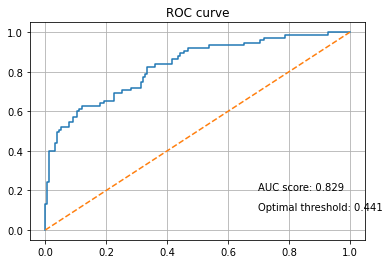

In [15]:
ROC(y_test, grid_cv.predict_proba(X_test)[:,1]) ###roc를 통한 확인

앙상블 분류 방법

In [16]:
from numpy import array

estimators_dict = {}
for alg in [
    'decision',
    'logistic',
    'kn']:
    matched_row = return_matched_row(cv_result_by_alg.reset_index(drop=True), 'algorithm', alg)
    clf_params = eval(return_params(matched_row.params_str.item()))
    clf = eval(matched_row['algorithm'].item())
    scaler = matched_row['param_scaler'].item()
    if scaler != scaler:
        scaler=None
        
    clf.set_params(**clf_params) 
    estimators_dict[alg] = Pipeline( [('scaler', scaler), ('estimator', clf)])

In [17]:
return_matched_row(cv_result_by_alg.reset_index(drop=True), 'algorithm', 'logistic').params_str.item()

"{'estimator': LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',\n                   solver='saga'), 'estimator__l1_ratio': 0.5, 'estimator__tol': 0.0001, 'scaler': MinMaxScaler()}"

In [18]:
estimators = dict2tuplist(estimators_dict)
estimators

[('decision',
  Pipeline(steps=[('scaler', None),
                  ('estimator',
                   DecisionTreeClassifier(criterion='entropy', max_depth=8,
                                          min_samples_split=64))])),
 ('logistic',
  Pipeline(steps=[('scaler', MinMaxScaler()),
                  ('estimator',
                   LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                      penalty='elasticnet', solver='saga'))])),
 ('kn',
  Pipeline(steps=[('scaler', RobustScaler()),
                  ('estimator',
                   KNeighborsClassifier(n_neighbors=21, weights='distance'))]))]

In [19]:
###최적화된 개별 모델에 대한 성능 출력
pd.DataFrame({alg: skfold_cv(model, X=X_train, y=y_train, pos_label=1).mean() for alg, model in estimators})

decision   logistic        kn
fold_ind  2.000000   2.000000  2.000000
auc       0.761154   0.788303  0.768311
acc       0.731862   0.730010  0.707459
tpr       0.528610   0.430499  0.460594
tnr       0.846121   0.898167  0.845993
f1        0.583317   0.533028  0.526465
ppv       0.662693   0.708713  0.620282
npv       0.763583   0.737823  0.738309
bacc      0.687366   0.664333  0.653293
fpr       0.471390   0.569501  0.539406
fnr       0.153879   0.101833  0.154007
plr       1.202262   0.794928  0.995117
nlr       6.218431  11.474444  5.932540

소프트보팅

In [51]:
best_estimators = estimators_dict.copy()
ensemble_clf = Pipeline([
    ('clfs', VotingClassifier(estimators=dict2tuplist(best_estimators),
                             voting = 'soft',
                              weights=[1,1,2]
                             ))])

In [52]:
ensemble_clf

Pipeline(steps=[('clfs',
                 VotingClassifier(estimators=[('decision',
                                               Pipeline(steps=[('scaler', None),
                                                               ('estimator',
                                                                DecisionTreeClassifier(criterion='entropy',
                                                                                       max_depth=8,
                                                                                       min_samples_split=64))])),
                                              ('logistic',
                                               Pipeline(steps=[('scaler',
                                                                MinMaxScaler()),
                                                               ('estimator',
                                                                LogisticRegression(l1_ratio=0.5,
                                                

In [53]:
ensemble_clf.fit(X_train,y_train)

Pipeline(steps=[('clfs',
                 VotingClassifier(estimators=[('decision',
                                               Pipeline(steps=[('scaler', None),
                                                               ('estimator',
                                                                DecisionTreeClassifier(criterion='entropy',
                                                                                       max_depth=8,
                                                                                       min_samples_split=64))])),
                                              ('logistic',
                                               Pipeline(steps=[('scaler',
                                                                MinMaxScaler()),
                                                               ('estimator',
                                                                LogisticRegression(l1_ratio=0.5,
                                                

In [66]:
binary_clf_eval(y_test, ensemble_clf.predict_proba(X_test))[['auc','acc','f1','tpr','tnr']] ###soft voting

auc       acc        f1       tpr       tnr
0  0.812906  0.770563  0.607407  0.546667  0.878205

In [82]:
binary_clf_eval(y_test, grid_cv.predict_proba(X_test)[:,1])[['auc','acc','f1','tpr','tnr']] ###grid search, 위의 소프트 보팅과 비교

auc       acc        f1       tpr       tnr
0  0.82906  0.796537  0.629921  0.533333  0.923077

In [67]:
skfold_cv(ensemble_clf, X=X_train, y = y_train).mean() ####아래의 개별모델보다 더좋은 auc값을 확인

fold_ind    2.000000
auc         0.793479
acc         0.724368
tpr         0.456275
tnr         0.875064
f1          0.541417
ppv         0.676443
npv         0.742065
bacc        0.665670
fpr         0.543725
fnr         0.124936
plr         0.864464
nlr         7.596429
dtype: float64

In [68]:
pd.DataFrame({alg: skfold_cv(model, X=X_train, y=y_train, pos_label=1).mean() for alg, model in estimators})

decision   logistic        kn
fold_ind  2.000000   2.000000  2.000000
auc       0.765321   0.788107  0.767021
acc       0.715092   0.729837  0.711388
tpr       0.548853   0.440216  0.476923
tnr       0.808397   0.892370  0.843009
f1        0.577882   0.539064  0.543555
ppv       0.623321   0.702561  0.634590
npv       0.763540   0.739802  0.741505
bacc      0.678625   0.666293  0.659966
fpr       0.451147   0.559784  0.523077
fnr       0.191603   0.107630  0.156991
plr       1.307311   0.819621  0.914286
nlr       4.791667  10.082650  5.733616

앙상블 분류에 대한 ROC곡선 

{'AUC': 0.8129059829059829, 'opt_thres': 0.4510822798947515}

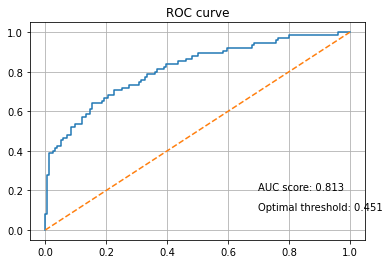

In [65]:
ROC(y_test, ensemble_clf.predict_proba(X_test)[:,1]) ###soft voting

하드보팅

In [69]:
ensemble_clf2 = Pipeline([
    ('clfs', VotingClassifier(estimators=dict2tuplist(best_estimators),
                             voting = 'hard',
                              weights=[1,1,2]
                             ))])
ensemble_clf2

Pipeline(steps=[('clfs',
                 VotingClassifier(estimators=[('decision',
                                               Pipeline(steps=[('scaler', None),
                                                               ('estimator',
                                                                DecisionTreeClassifier(criterion='entropy',
                                                                                       max_depth=8,
                                                                                       min_samples_split=64))])),
                                              ('logistic',
                                               Pipeline(steps=[('scaler',
                                                                MinMaxScaler()),
                                                               ('estimator',
                                                                LogisticRegression(l1_ratio=0.5,
                                                

In [70]:
 pd.DataFrame(skfold_cv(ensemble_clf2, X=X_train, y=y_train, random_state = 3, predict_method='predict').mean()).T[['auc','acc','f1','tpr','tnr']]

auc       acc        f1       tpr       tnr
0  0.658846  0.724438  0.525972  0.425236  0.892455

스태킹

In [78]:
grid_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator',
                 LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                    penalty='elasticnet', solver='saga'))])

In [79]:
### 로지스틱 스태킹
stacking_clf = Pipeline([
    ('estimators', StackingClassifier(estimators=dict2tuplist(best_estimators),
                                      cv=5, final_estimator = estimators_dict['logistic'],
                                     stack_method='predict_proba', verbose = 3))
])

stacking_clf.fit(X_train,y_train)
binary_clf_eval(y_test, stacking_clf.predict_proba(X_test))[['auc','acc','f1','tpr','tnr']]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


auc       acc        f1   tpr       tnr
0  0.824274  0.796537  0.641221  0.56  0.910256

In [80]:
skfold_cv(stacking_clf, X=X_train, y = y_train).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

fold_ind    2.000000
auc         0.793850
acc         0.720734
tpr         0.482321
tnr         0.854731
f1          0.553091
ppv         0.656077
npv         0.746680
bacc        0.668526
fpr         0.517679
fnr         0.145269
plr         0.951261
nlr         6.515714
dtype: float64

{'AUC': 0.8236752136752137, 'opt_thres': 0.4345342212573038}

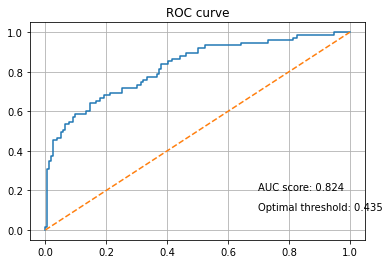

In [81]:
ROC(y_test, stacking_clf.predict_proba(X_test)[:,1]) 

개별 모델, 앙상블 방법 적용 성능 평가 종합적으로 비교하여 표 만들기

In [83]:
finaldf = pd.DataFrame({'name':['gridsearch', 'softvoting', 'hardvoting', 'stacking'],
                       'auc': [0.82906, 0.801368, 0.658846, 0.842474],
                       'acc': [0.796537, 0.761905, 0.724438, 0.796537],
                       'f1': [0.629921, 0.586466, 0.525972, 0.641221],
                       'tpr': [0.533333, 0.52, 0.425236, 0.56],
                       'tnr': [0.923077, 0.878205, 0.892455, 0.910256]})

finaldf

name       auc       acc        f1       tpr       tnr
0  gridsearch  0.829060  0.796537  0.629921  0.533333  0.923077
1  softvoting  0.801368  0.761905  0.586466  0.520000  0.878205
2  hardvoting  0.658846  0.724438  0.525972  0.425236  0.892455
3    stacking  0.842474  0.796537  0.641221  0.560000  0.910256